# 1. Information about the submission

## 1.1 Name and number of the assignment

2. RUSSE-2022 Detoxification

## 1.2 Student name

Denis Isaev

## 1.3 Codalab user ID / nickname / username

denzelito

## 1.4 Additional comments

**Порядок выполнения работы:**
- Переписал обработку данных на мэппинг фукнкций на Dataset-формате из либы datasets. <br> Так для меня гораздо понятнее и прозрачнее, что я делаю с данными и в каком виде их передаю в модель.
- Написал процесс обучения под себя на примере модели T5.<br>
Использованы:<br>
> косинусное изменение learning_rate с прогревом в начале<br>
10 эпох обучения<br>
скор на валидации в конце каждой эпохи<br>
ранняя остановка в случае, если скор на валидации не улучшается в течении послдених n эпох<br>
подгружаем лучшую среди всех эпох модель
- тестирование температуры и beam-ов при генерации текста
- инференс модели - сохраняем предсказаний для валидационной и тестовой выборок
- скоринг сохраненных файлов
- эксперименты с использованием других предобученных моделей
<br>
<br>
первоначально работал на Colab-е, но столкнулся с тем, что Colab ограничил доступ к GPU, перешел на обучение на доступном мне ресурсе

# 2. Technical Report

*Use Section 2 to describe results of your experiments as you would do writing a paper about your results. DO NOT insert code in this part. Only insert plots and tables summarizing results as needed. Use formulas if needed do described your methodology. The code is provided in Section 3.*

https://github.com/s-nlp/russe_detox_2022.git

https://codalab.lisn.upsaclay.fr/competitions/642


## 2.1 Methodology

*   схема подготовки данных следующая: <br>
tsv-file -> pandas -> preproc -> Dataset ->  -> function map -> DataLoader

*   использовалась модель **t5-base** <br>
> это ванильный энкодер-декодер трансформер, но без байеса в линейной нормализации, сама нормализация стоит до внимания и полносвязного слоев, а также вместо позиционного энкодинга входных токенов исполузется relative positions<br>
пытался использовать другие модели - сталкивался с ошибкой нехватки памяти на видеокарте
*   в качестве валидационного датасета был взят датасет dev.tsv, так как там есть разметка
*   в качестве гиперпараметров, которые выбирались итеративным путем, выступали *температура* и *кол-во бимов* на этапе генерации текста
*   обучение модели проиходило внутри цикла, написанного самостоятельно
*   для инференса использовалась функция paraphrase родительского репозитория
*   метрики:
> Style Transfer Accuracy (STA) - перенос стиля <br>
Meaning Preservation Score (SIM) - сохранение смысла высказывания <br>
Fluency score (FL) - естественность текста <br>
Joint score (J) = STA * SIM * FL <br>
ChrF1 - f-мера по символьным совпадениям (из автоматических метрик, ближе всего к человеческой оценке)<br>
 **ключевая - J**


## 2.2 Discussion of results

Смотря на процесс обучения модели видно, что по эпохам модель очень быстро перестала улучшаться - вторая эпоха является лучше по валидационному лоссу.

Ниже влияние количества бимов и температуры на метрику J.

beam | temperature | J
---|---|----
3 | 0.0 | 0,369043552
3 | 0.1 | 0,369043552
3 | 0.5 | 0,369043552
3 | 1 | 0,369043552
3 | 5 | 0,369043552
3 | 10 | 0,369043552
3 | 25 | 0,369043552
3 | 50 | 0,369043552
20 | 0 | 0,3696025631
10 | 0 | 0,3691694147
5 | 0 | 0,3701079725

Наилучший результат: T=0, B=5 - эта версия и передавалась на post-evaluation.

Итоговые результаты на Codalab:

Method | dev_J| test_J
--- | --- | ---
baseline | 0.36 | 0.41
ruT5-base | 0.37 | 0.43

Модель выше baseline модели delete на обоих тестовых датасетах.

# 3. Code

## 3.1 Requirements

In [1]:
pip install transformers sentencepiece datasets transformers[torch]

In [2]:
import pandas as pd
import numpy as np
import gc
import re
import sys
import shutil
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from tqdm.auto import tqdm, trange
from glob import glob

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from datasets import Dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

torch.manual_seed(73)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 3.2 Download the data

In [3]:
!git clone https://github.com/s-nlp/russe_detox_2022.git
!ls russe_detox_2022/data
!ls russe_detox_2022/data/input

Cloning into 'russe_detox_2022'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 81
Receiving objects: 100% (82/82), 40.90 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (28/28), done.
input  output  README.md
dev.tsv  test.tsv  train.tsv


In [5]:
train = pd.read_csv('russe_detox_2022/data/input/train.tsv', sep='\t')
val = pd.read_csv('russe_detox_2022/data/input/dev.tsv', sep='\t')
test = pd.read_csv('russe_detox_2022/data/input/test.tsv', sep='\t')

print('train shape:', train.shape)
print('valid shape:', val.shape)
print('test  shape:', test.shape)

train.head(2)

train shape: (6948, 5)
valid shape: (800, 4)
test  shape: (875, 1)


,index,toxic_comment,neutral_comment1,neutral_comment2,neutral_comment3
0,0,"и,чё,блядь где этот херой был до этого со свои...","Ну и где этот герой был,со своими доказательст...",Где этот герой был до этого со своими доказате...,"и,где этот герой был до этого со своими доказа..."
1,1,"О, а есть деанон этого петуха?","О, а есть деанон",NaN,NaN


## 3.3 Preprocessing

In [6]:
def dataframe_change(dataset):
  df_id = []
  df_toxic = []
  df_neutral = []
  for index, row in dataset.iterrows():
      references = row[['neutral_comment1', 'neutral_comment2', 'neutral_comment3']].tolist()
      for reference in references:
          df_id.append(index)
          df_toxic.append(row['toxic_comment'])
          df_neutral.append(reference)
  df = pd.DataFrame({
      'comment_id': df_id,
      'toxic_comment': df_toxic,
      'neutral_comment': df_neutral
  }).dropna().reset_index(drop=True)
  df['len'] = df['toxic_comment'].apply(len)
  df = df.sort_values('len').drop(columns=['len'])
  return df

train_df = dataframe_change(train)
val_df = dataframe_change(val)
test_df = test.copy()

https://github.com/alexey-zhavoronkin/russe_detox_solution/

## 3.4 My method of text processing

ai-forever/rugpt3small_based_on_gpt2 <br>
AutoModelForCausalLM

In [7]:
model_name = 'ai-forever/ruT5-base'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [8]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [9]:
def train_preparation(batched_text):
  x = tokenizer(batched_text['toxic_comment'], padding='max_length', truncation=True, max_length=512)
  y = tokenizer(batched_text['neutral_comment'], padding='max_length', truncation=True, max_length=512)
  answer = {k: val for k, val in x.items()}
  answer['decoder_attention_mask'] = y['attention_mask']
  answer['labels'] = y['input_ids']
  return answer

def test_preparation(batched_text):
  x = tokenizer(batched_text['toxic_comment'], padding='max_length', truncation=True, max_length=512)
  answer = {k: val for k, val in x.items()}
  return answer

In [10]:
tokenized_train_dataset = train_dataset.map(train_preparation, batched=True, batch_size=32)
tokenized_val_dataset = val_dataset.map(train_preparation, batched=True, batch_size=32)
tokenized_test_dataset = test_dataset.map(test_preparation, batched=True, batch_size=32)

tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'decoder_attention_mask', 'labels'])
tokenized_val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'decoder_attention_mask', 'labels'])
tokenized_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])
tokenized_train_dataset

Map:   0%|          | 0/11090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1116 [00:00<?, ? examples/s]

Map:   0%|          | 0/875 [00:00<?, ? examples/s]

Dataset({
    features: ['comment_id', 'toxic_comment', 'neutral_comment', '__index_level_0__', 'input_ids', 'attention_mask', 'decoder_attention_mask', 'labels'],
    num_rows: 11090
})

## 3.5 train model

In [11]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [12]:
batch_size = 8
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(tokenized_val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=batch_size, shuffle=True)
cleanup()

In [ ]:
# ========================================
#             Training config
# ========================================
max_epochs = 10
early_stopping_count = 5
gradient_accumulation_steps = 1
window = 100
model_save_path = 'russe_detox_2022/data/output'
model_save_name = 't5_base'
# ========================================
#              LR optimizer
# ========================================
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps =  len(train_dataloader) * max_epochs
num_warmup_steps = int(num_training_steps * 0.10)
lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer,
                                                                  num_warmup_steps=num_warmup_steps,
                                                                  num_training_steps=num_training_steps,
                                                                  num_cycles=3)
lr_list = []
validation_losses = []
step = 0
train_loss = 0
val_best_loss = 9e9
for epoch in trange(max_epochs):
    # ========================================
    #                Training
    # ========================================
    model.train()
    tq = tqdm(train_dataloader)
    running_loss = 0
    for i, batch in enumerate(tq):
        batch['labels'][batch['labels']==0] = -100
        loss = model(**{k: v.to(model.device) for k, v in batch.items()}).loss
        loss.backward()
        if i % gradient_accumulation_steps == 0:
          optimizer.step()
          lr_scheduler.step()
          lr_list.append(optimizer.param_groups[0]['lr'])
          optimizer.zero_grad()
        running_loss += loss.item()
        avg_train_loss = running_loss / len(train_dataloader)

        cleanup()

        w = 1 / min(i+1, window)
        train_loss = train_loss * (1-w) + loss.item() * w
        tq.set_description(f'window train loss: {train_loss:4.4f}')
    # ========================================
    #               Validation
    # ========================================
    model.eval()
    val_loss = 0
    val_tq = tqdm(val_dataloader)
    val_tq.set_description(f'valid scoring...    ')
    for batch in val_tq:
        with torch.no_grad():
            loss = model(**{k: v.to(model.device) for k, v in batch.items()}).loss
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_dataloader)
    validation_losses.append(avg_val_loss)
    if avg_val_loss < val_best_loss:
        val_best_loss = avg_val_loss

    print(f'epoch {epoch+1}, step {i+1}/{num_training_steps}: train loss: {avg_train_loss:4.4f}  val loss: {avg_val_loss:4.4f}')
    model.save_pretrained(f'{model_save_path}/{model_save_name}_{epoch+1}')
    # ========================================
    #              Early stopping
    # ========================================
    if len(validation_losses) > early_stopping_count:
        if val_best_loss < min(validation_losses[-early_stopping_count:]):
            print('!early stopping')
            break
# ========================================
#              Best model
# ========================================
best_model_index = np.argmin(validation_losses)+1

# убираем за собой =)
for file_i in glob(f'{model_save_path}/{model_save_name}_*'):
    file_epoch = re.findall("\d+", file_i)[-1]
    if int(file_epoch) != best_model_index:
        shutil.rmtree(file_i)
model = T5ForConditionalGeneration.from_pretrained(f'{model_save_path}/{model_save_name}_{best_model_index}', local_files_only=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 1, step 1387/13870: train loss: 3.6230  val loss: 15.3875


  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 2, step 1387/13870: train loss: 1.6966  val loss: 14.7006


  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 3, step 1387/13870: train loss: 1.4253  val loss: 15.4569


  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 4, step 1387/13870: train loss: 1.2921  val loss: 15.4652


  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 5, step 1387/13870: train loss: 1.2977  val loss: 15.0090


  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 6, step 1387/13870: train loss: 1.1061  val loss: 15.7060


  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

epoch 7, step 1387/13870: train loss: 0.9906  val loss: 16.0365
!early stopping


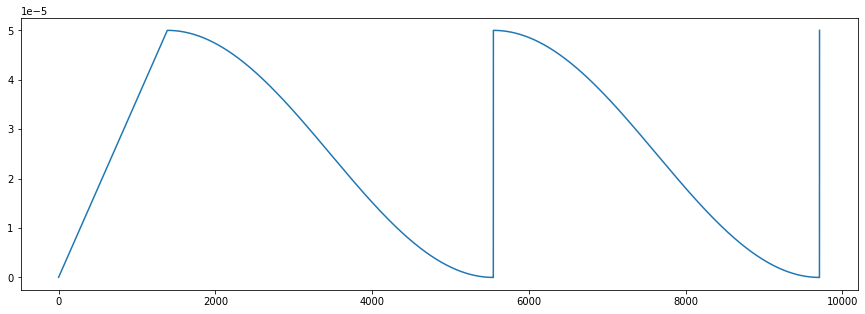

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(lr_list)
plt.show()

## 3.6 inference

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(f'{model_save_path}/{model_save_name}_{best_model_index}', local_files_only=True)
model.to(device)

In [ ]:
def paraphrase(text, model, n=None, max_length='auto', temperature=0.0, beams=3):
    texts = [text] if isinstance(text, str) else text
    inputs = tokenizer(texts, return_tensors='pt', padding=True)['input_ids'].to(model.device)
    if max_length == 'auto':
        max_length = int(inputs.shape[1] * 1.2) + 10
    result = model.generate(
        inputs,
        num_return_sequences=n or 1,
        do_sample=False,
        temperature=temperature,
        repetition_penalty=3.0,
        max_length=max_length,
        bad_words_ids=[[2]],  # unk
        num_beams=beams,
    )
    texts = [tokenizer.decode(r, skip_special_tokens=True) for r in result]
    if not n and isinstance(text, str):
        return texts[0]
    return texts

In [ ]:
print(paraphrase(['Дмитрий вы ебанулись, уже все выложено'], model, temperature=50.0, beams=10))

['Дмитрий, уже все выложено']


In [ ]:
print(paraphrase(['вот, теперь видите что я охуенными вещами занимаюсь?'], model, temperature=0.0, beams=10))

['Вот видите что я офигенными вещами занимаюсь?']


### meta-parameters selection

- при повышении значения temperature распределение вероятностей слов начинает приближаться к равномерному, и наоборот: чем меньше, тем острее
- beam - кол-во одновременно строящихся вариантов предложения

In [ ]:
for T in tqdm([0.0, 0.1, 0.5, 1, 5, 10, 25, 50]):
    para_results = []
    problematic_batch = [] #if something goes wrong you can track such bathces
    batch_size = 8

    toxic_inputs = val.toxic_comment.tolist()
    for i in tqdm(range(0, len(toxic_inputs), batch_size)):
        batch = [sentence for sentence in toxic_inputs[i:i + batch_size]]
        try:
            para_results.extend(paraphrase(batch, model, temperature=T))
        except Exception as e:
            print(i)
            para_results.append(toxic_inputs[i:i + batch_size])
    assert len(toxic_inputs) == len(para_results), 'расхождение между количеством предсказаний и true-лэйблов'
    # txt-file
    with open(f'dev_results_T{str(T)}.txt', 'w') as file:
        file.writelines([sentence+'\n' for sentence in para_results])
    # zip-file
    with ZipFile(f'russe_detox_2022/data/output/dev_results_T{str(T)}.zip', 'w') as f:
        f.write(f'dev_results_T{str(T)}.txt')
    # remove txt-file
    os.remove(f'dev_results_T{str(T)}.txt')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
for B in tqdm([3, 5, 10, 20]):
    para_results = []
    problematic_batch = [] #if something goes wrong you can track such bathces
    batch_size = 8

    toxic_inputs = val.toxic_comment.tolist()
    for i in tqdm(range(0, len(toxic_inputs), batch_size)):
        batch = [sentence for sentence in toxic_inputs[i:i + batch_size]]
        try:
            para_results.extend(paraphrase(batch, model, temperature=0.0, beams=B))
        except Exception as e:
            print(i)
            para_results.append(toxic_inputs[i:i + batch_size])
    assert len(toxic_inputs) == len(para_results), 'расхождение между количеством предсказаний и true-лэйблов'

    # txt-file
    with open(f'dev_results_B{str(T)}.txt', 'w') as file:
        file.writelines([sentence+'\n' for sentence in para_results])
    # zip-file
    with ZipFile(f'russe_detox_2022/data/output/dev_results_B{str(B)}.zip', 'w') as f:
        f.write(f'dev_results_B{str(T)}.txt')
    # remove txt-file
    os.remove(f'dev_results_B{str(T)}.txt')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### test dataset scoring

In [ ]:
para_results = []
problematic_batch = [] #if something goes wrong you can track such bathces
batch_size = 8

toxic_inputs = test.toxic_comment.tolist()
for i in tqdm(range(0, len(toxic_inputs), batch_size)):
    batch = [sentence for sentence in toxic_inputs[i:i + batch_size]]
    try:
        para_results.extend(paraphrase(batch, model, temperature=0.0, beams=5))
    except Exception as e:
        print(i)
        para_results.append(toxic_inputs[i:i + batch_size])
print(len(toxic_inputs) == len(para_results))
with open('test_results.txt', 'w') as file:
    file.writelines([sentence+'\n' for sentence in para_results])
with ZipFile('russe_detox_2022/data/output/test_results.zip', 'w') as f:
        f.write('test_results.txt')
os.remove('test_results.txt')